# Fun with Classification

This comparison of classification techniques was done for IBM's Data Science with Python course on Coursera. The dataset, on loan defaults, was provided by the course. Intentionally, or unintentionally, this exercise is a good lesson in always comparing the results of a machine learning model against those of a "null" model!

In [1]:
# Import libraries

# Data wrangling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modeling tools
from sklearn. preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

## Data Wrangling

### The Dataset

The dataset consists of data on 346 customers of a short-term loan business, with the following fields:

* Loan Status: The target variable, whether the loan was paid off or defaulted
* Principal: The amount of the loan
* Terms: The payoff schedule
* Effective Date: When the loan was taken out
* Due Date: When the loan was due
* Age: Age of the borrower
* Education: Education level of the borrower
* Gender: Gender of the borrower

This dataset was provided as separate train and test sets, in two csv files <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv">here</a> and <a href="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv">here</a>. I left all typos in the dataset as is, e.g. "Bechalor".

### Load Training Set

In [2]:
df = pd.read_csv("loan_train.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
# It seems this file was twice saved to csv from pandas without specifying index=False. 
# Drop the first two columns.

df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loan_status     346 non-null    object
 1   Principal       346 non-null    int64 
 2   terms           346 non-null    int64 
 3   effective_date  346 non-null    object
 4   due_date        346 non-null    object
 5   age             346 non-null    int64 
 6   education       346 non-null    object
 7   Gender          346 non-null    object
dtypes: int64(3), object(5)
memory usage: 21.8+ KB


No null values, good. Dates would be more useful as datatime objects, however. There are two categorical predictor variables here: education and gender. The target variable, loan_status is also categorical. But first, a little data exploration...

### Data Exploration

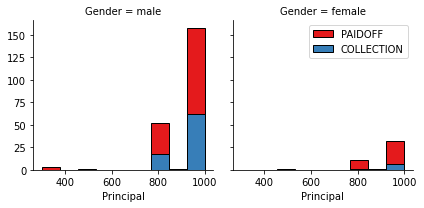

In [5]:
# Does gender, principal, or age make a difference?

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, "Principal", bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

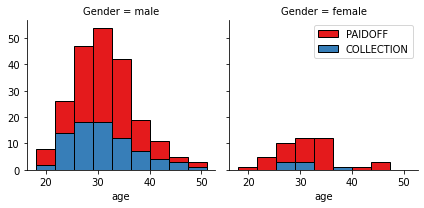

In [6]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, "age", bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Hmm. Got to watch out for men in their mid-40s!

In [7]:
df.groupby(["Gender"])["loan_status"].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Overall, men go into collection more often.

In [8]:
df.groupby(["education"])["loan_status"].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Interestingly, the customers with the highest education level, "Master or Above" are more likely to go into collection. The other groups are fairly close to each other. Out of curiosity, how many customers fall into the "Master and Above" category?

In [9]:
df["education"].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

Okay, that's what I guessed. There are only two, so the difference in paid off rate may not be that meaningful.

One very important question: overall, what percent of loand are paid off?

In [10]:
df["loan_status"].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [11]:
print(f"{260 / (260 + 86):0.2%} of loans are paid off on time.")

75.14% of loans are paid off on time.


This means that if a model is less than 75.14% accurate, it is actually doing *worse* than a null model that simply predicts the mode (PAIDOFF) all the time!

### Convert Variables, Feature Extraction, Etc.

In [12]:
# Convert dates to datetimes

df["due_date"] = pd.to_datetime(df["due_date"])
df["effective_date"] = pd.to_datetime(df["effective_date"])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


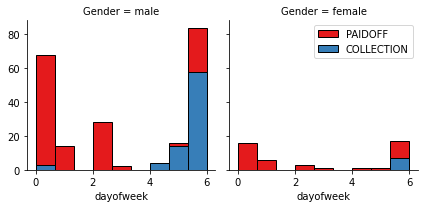

In [13]:
# Extract day of the week

df["dayofweek"] = df["effective_date"].dt.dayofweek

bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, "dayofweek", bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Note that 0 is Monday and 6 is Sunday. Customers who take out loans on days 4, 5, and 6 (Friday, Saturday, and Sunday) appear less likely to pay them off on time. Let's create a categorical variable to capture this. "Weekend" will be 0 for Monday through Thurday (0 to 3) and 1 for Friday through Sunday (4 to 6).

In [14]:
# Create weekend feature

df["weekend"] = df["dayofweek"].apply(lambda x: 1 if (x>3) else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [15]:
# Convert Gender to numerical (male = 0, female = 1)

df["Gender"].replace({"male":0 , "female": 1}, inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [16]:
# Use one hot encoding on education and finalize the feature set

Feature = df[["Principal", "terms", "age", "Gender", "weekend"]]
Feature = pd.concat([Feature, pd.get_dummies(df["education"])], axis=1)
Feature.drop(["Master or Above"], axis = 1, inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Note that "Master or Above" can be dropped as it is effectively encoded as 0 0 0 for the other three education categories. Relevant information from effective_date and dayofweek is encoded in weekend, so they are no longer needed. Due_date doesn't really give any additional information beyond what the term is and we already have that.

### Normalize!


For effective modeling, the data should be normalized. Standard Scaler produces Z scores, i.e. it shifts the mean to 0 and the variance to 1.

In [17]:
scaler = StandardScaler()

X = Feature
X = scaler.fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

The code snippets originally provided by the instructor to aid with this assignment separately scale the train and test data. It is my understanding, however, that the more proper way to do this is to fit to the train data and use the same scaler to transform both datasets. That is what I have done here.

In [18]:
# And finally, the labels / target variable

y = df["loan_status"].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Classification

This assignment called for classifying the data using:

* K Nearest Neighbors (KNN)
* Decision Tree Classification
* Support Vector Classification (SVC)
* Logistic Regression

### K Nearest Neighbor (KNN)

I chose to split the training data into training and validation sets for the purposes of selecting the best value of k with a manual for loop. The same process could have been done with GridSearchCV, but I wanted to clarify what was going on.

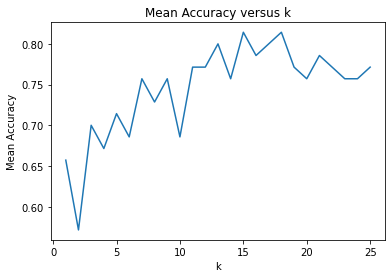

Maximum model accuracy with k = 15


In [19]:
# First select best value of k

# Train test split of the data in loan_train.csv
# Use the test set to estimate the out of sample accuracy of each model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

max_k = 25 # set this to control max k value tested
Ks = np.arange(1, max_k + 1)

accuracy_scores = [] # initialize empty list to hold accuracy of each model

for k in Ks:
    model = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhat = model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, yhat))

plt.plot(Ks, accuracy_scores)
plt.title("Mean Accuracy versus k")
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.show()

print("Maximum model accuracy with k =", Ks[np.argmax(accuracy_scores)])

In [20]:
# Now retrain the model using k=15 and the entire loan_train.csv dataset so no information is lost.
# This is the model that will be evaluated below with the data in loan_test.csv.

KNN_model = KNeighborsClassifier(n_neighbors = 15).fit(X, y)
yhat = KNN_model.predict(X)
print(f"KNN model accuracy: {accuracy_score(y, yhat):0.2%}")

KNN model accuracy: 77.46%


Note that, at least on the training data set, the model accuracy is better than that of the "null" model.

### Decision Tree

There are a number of hyperparameters to tune with a Decision Tree. Here GridSearchCV is used to explore the accuracy for a variety of max_depth values and two splitting criteria, gini and entropy.

In [21]:
grid = {"max_depth": np.arange(2, 8), "criterion":["gini", "entropy"]}

# Note that there is no need to split X into train and test sets because GridSearchCV does crossfold validation.

grid_model = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), grid, scoring="accuracy", cv=5)
grid_model.fit(X, y)
print("Best hyperparameters are:", grid_model.best_params_)
print("Best accuracy score:", grid_model.best_score_)

Best hyperparameters are: {'criterion': 'gini', 'max_depth': 7}
Best accuracy score: 0.6332505175983437


In [22]:
# Retrain the model on the entire data in loan_train.csv using the best parameters from above.

# Pass the best hyperparameters to the model as an unpacked dictionary:
DT_model = DecisionTreeClassifier(**grid_model.best_params_) 
DT_model.fit(X, y)
yhat = DT_model.predict(X)
print(f"Decision Tree model accuracy: {accuracy_score(y, yhat):0.2%}")

Decision Tree model accuracy: 80.64%


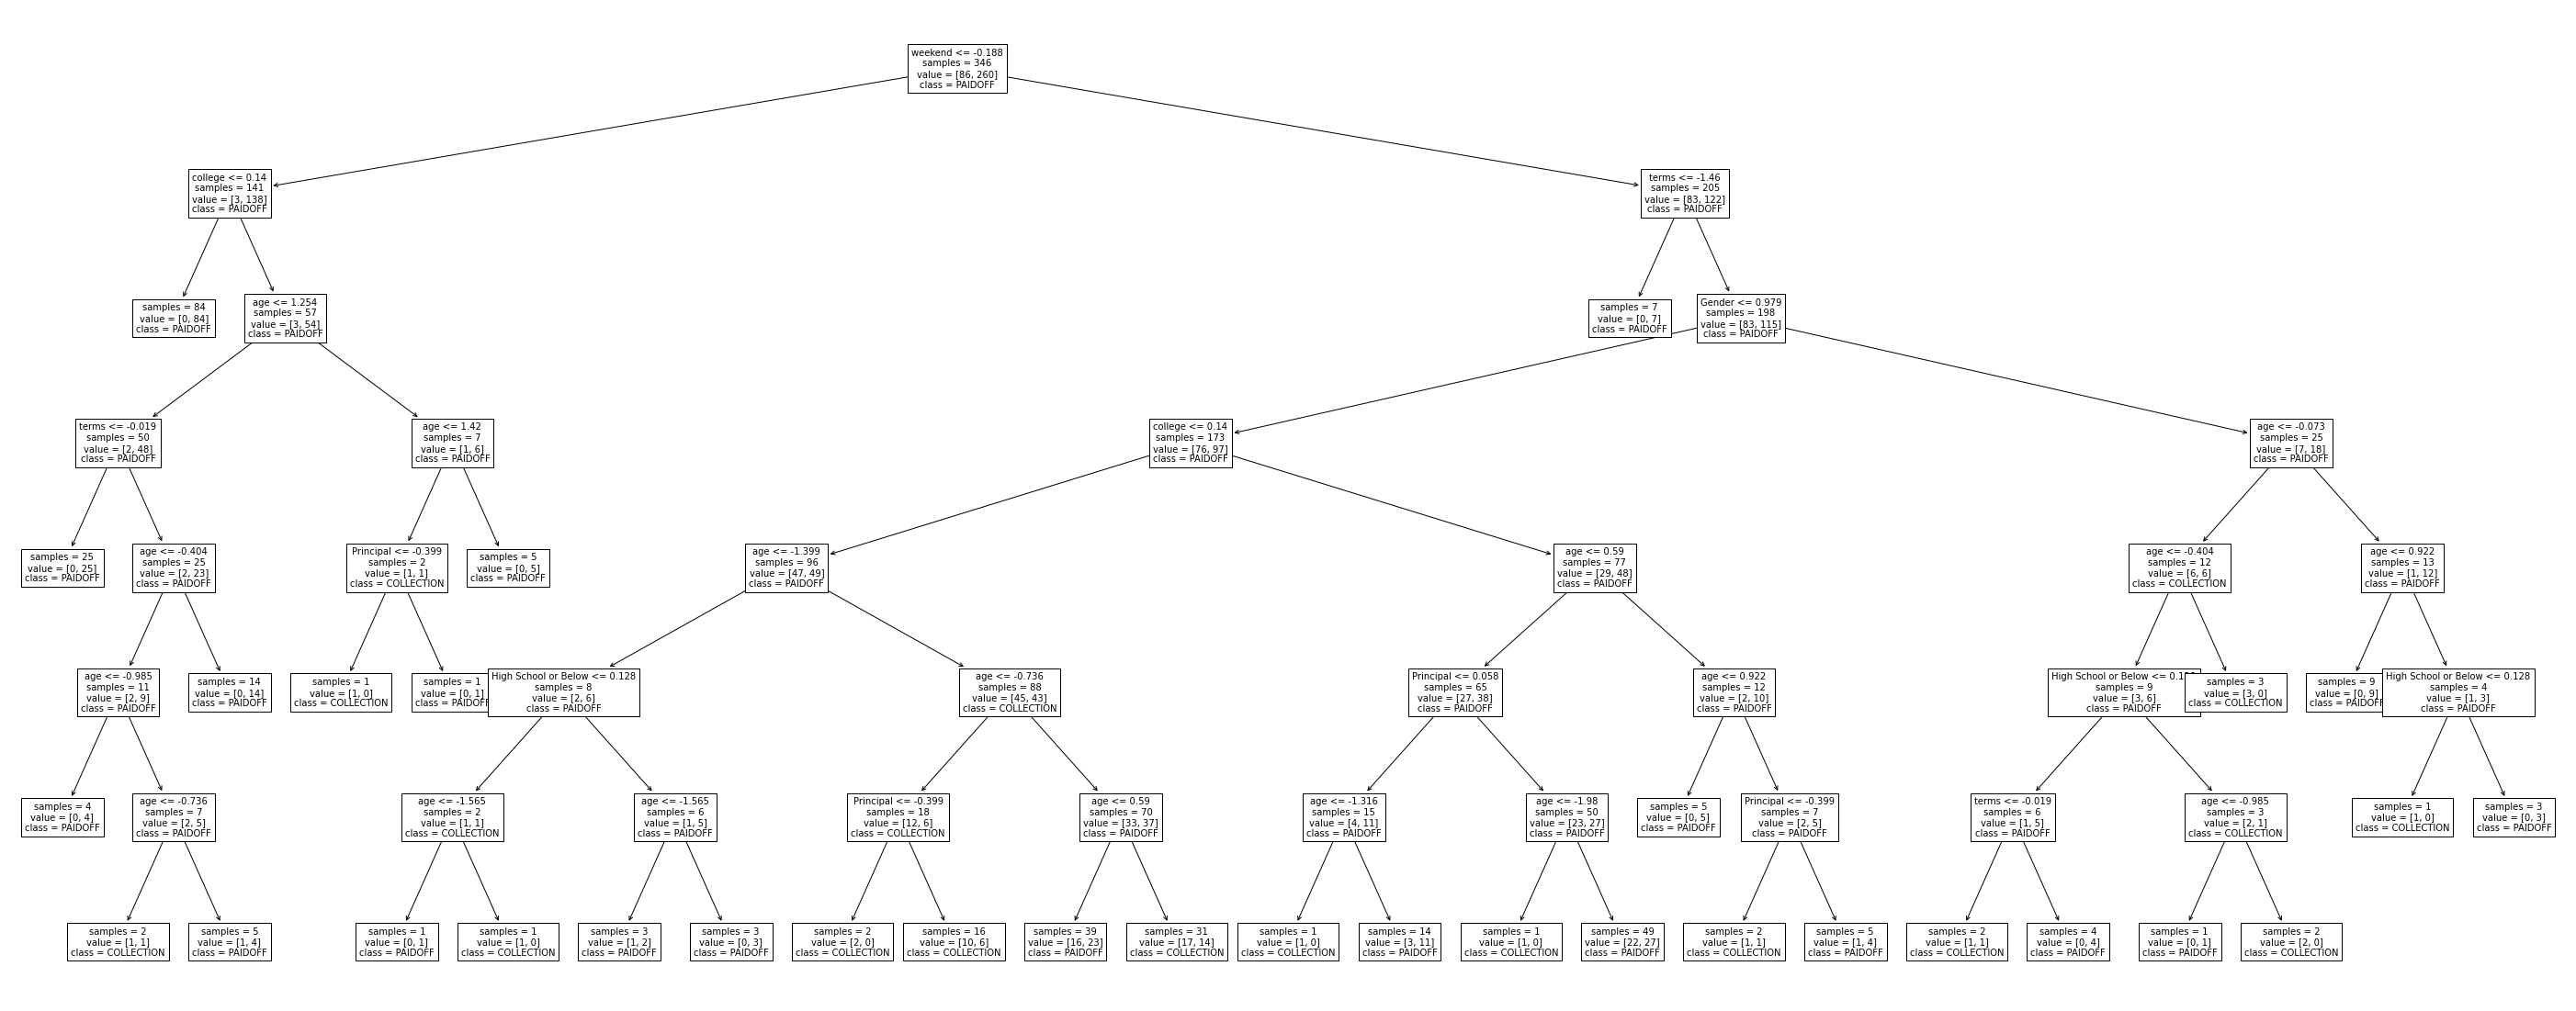

In [23]:
# Just for fun, a little tree visualization using scikit-learn's built-in plot_tree function

plt.figure(figsize=(50,20))
plot_tree(DT_model, feature_names=Feature.columns, class_names=DT_model.classes_, impurity=False, fontsize=10)
plt.show()

Considering that there are only eight feature variables, seven splits is a lot. I'm also rather concerned that the best accuracy obtained in GridCV is much lower than the accuracy of the model trained on all the data. I suspect overfitting. We'll see what happens with the test data set below!

Incidentally, many hyperparameter values result in models that predict PAIDOFF 100% of the time, with an accuracy of 75.14%, just as the "null" model.

In [24]:
# An example of a useless Decision Tree!

DT_model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model2.fit(X, y)
yhat = DT_model2.predict(X)
print(f"Decision Tree model accuracy: {accuracy_score(y, yhat):0.2%}")

Decision Tree model accuracy: 75.14%


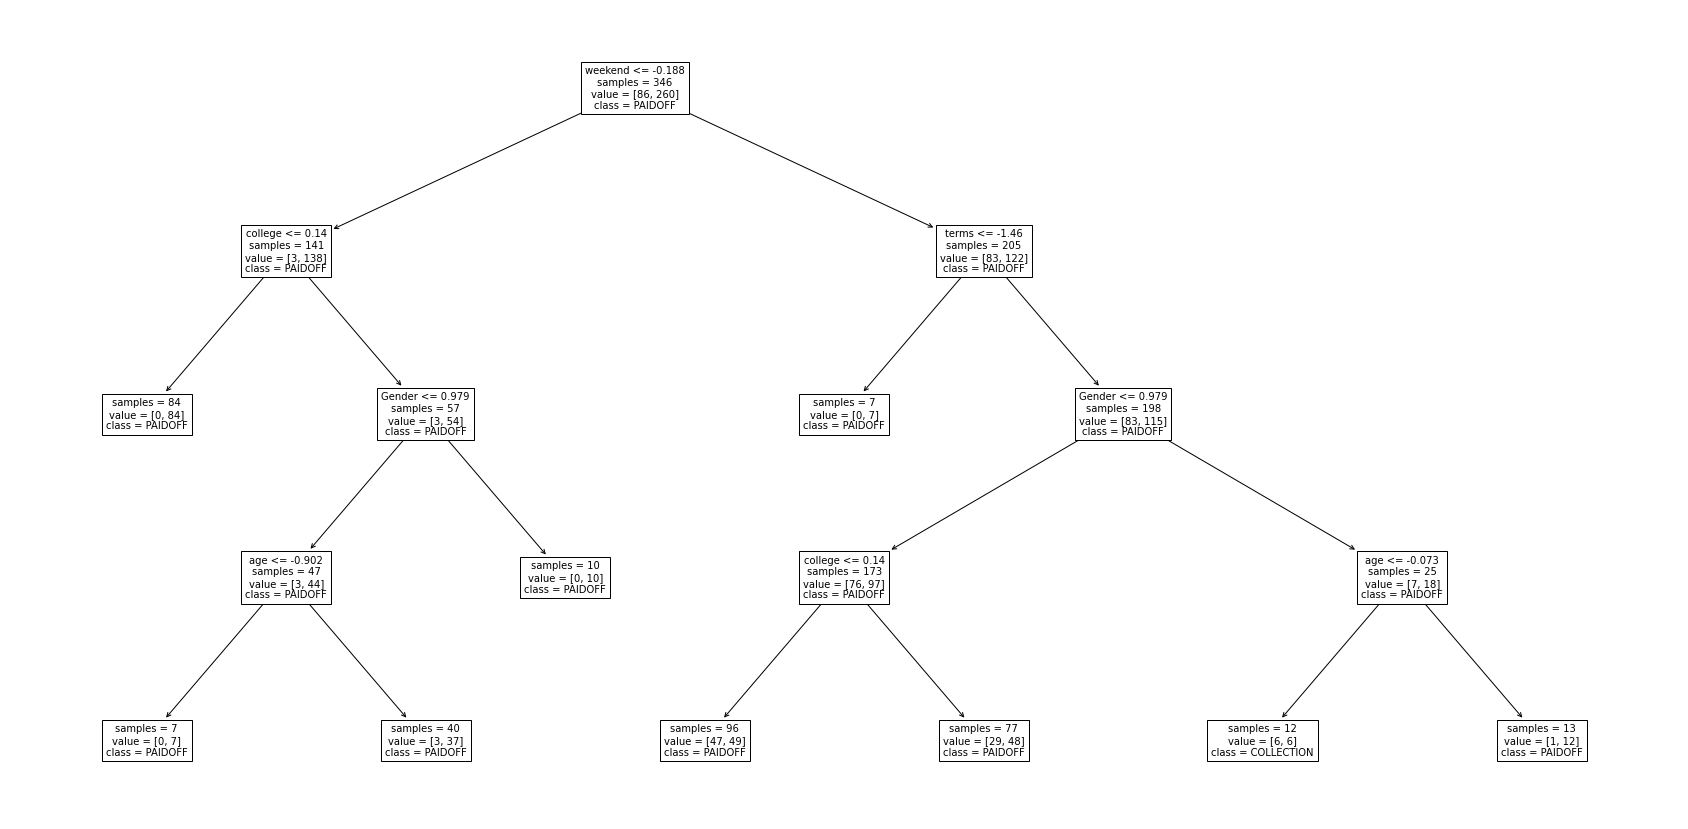

In [25]:
plt.figure(figsize=(30,15))
plot_tree(DT_model2, feature_names=Feature.columns, class_names=DT_model2.classes_, impurity=False, fontsize=10)
plt.show()

All PAIDOFF all the time!

### Support Vector Classifier

Scikit-learn's Support Vector Classifier comes with several kernel options. Use GridSearchCV to explore several.

In [26]:
grid = {"kernel": ["linear", "poly", "rbf", "sigmoid"]}

grid_model = GridSearchCV(SVC(), grid, scoring="accuracy", cv=5)
grid_model.fit(X, y)
print("Best hyperparameters are:", grid_model.best_params_)
print("Best accuracy score:", grid_model.best_score_)

Best hyperparameters are: {'kernel': 'poly'}
Best accuracy score: 0.7370186335403727


In [27]:
# Retrain the model with all of the data in loan_train.csv and the best kernel discovered above.

SVM_model = SVC(kernel="poly") 
SVM_model.fit(X, y)
yhat = SVM_model.predict(X)
print(f"SVM model accuracy: {accuracy_score(y, yhat):0.2%}")

SVM model accuracy: 78.03%


### Logistic Regression

Use GridSearchCV to explore the accuracy of several values of C and several types of solvers. C is a regularization hyperparameter. Smaller values of C provide stronger regularization.

In [28]:
grid = {"C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "lbfgs", "newton-cg"] 
       }

grid_model = GridSearchCV(LogisticRegression(), grid, scoring="accuracy", cv=5)
grid_model.fit(X, y)
print("Best hyperparameters are:", grid_model.best_params_)
print("Best accuracy score:", grid_model.best_score_)

Best hyperparameters are: {'C': 0.01, 'solver': 'lbfgs'}
Best accuracy score: 0.7514699792960663


In [29]:
# Retrain the model with all of the data in loan_train.csv and the best solver discovered above.

LR_model = LogisticRegression(C=0.01, solver="lbfgs")
LR_model.fit(X, y)
yhat = LR_model.predict(X)
print(f"Logistic Regression model accuracy: {accuracy_score(y, yhat):0.2%}")

Logistic Regression model accuracy: 75.14%


Only as good as guessing PAIDOFF all the time.

## Model Evaluation Using Test Set

Any data splits of the training set above were for the purpose of hyperparameter tuning. All models produced above were re-trained on the entire training set after hyperparameters were selected.

The models will now be evaluated on the test set provided in a separate csv file by the course.

### Load Test Set

In [30]:
test_df = pd.read_csv("loan_test.csv")
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [31]:
# Drop the useless columns.

test_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [32]:
# 54 rows, no nulls, same datatypes as the training set.

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loan_status     54 non-null     object
 1   Principal       54 non-null     int64 
 2   terms           54 non-null     int64 
 3   effective_date  54 non-null     object
 4   due_date        54 non-null     object
 5   age             54 non-null     int64 
 6   education       54 non-null     object
 7   Gender          54 non-null     object
dtypes: int64(3), object(5)
memory usage: 3.5+ KB


In [33]:
# Check target distribution of test set.

test_df["loan_status"].value_counts(normalize=True)

PAIDOFF       0.740741
COLLECTION    0.259259
Name: loan_status, dtype: float64

Note that a null model predicting PAIDOFF all the time would have an accuracy of 74.07%.

### Transform Test Set

In order to use the loan_test data, it needs to be pre-processed in the same manner as loan_train. In real life, it would be better to make this transformation a function, so I don't have to real type it!

In [34]:
# Convert dates to datetimes and extract weekday and weekend

test_df["effective_date"] = pd.to_datetime(test_df["effective_date"])
test_df["dayofweek"] = test_df["effective_date"].dt.dayofweek
test_df["weekend"] = test_df["dayofweek"].apply(lambda x: 1 if (x>3) else 0)
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,10/7/2016,50,Bechalor,female,3,0
1,PAIDOFF,300,7,2016-09-09,9/15/2016,35,Master or Above,male,4,1
2,PAIDOFF,1000,30,2016-09-10,10/9/2016,43,High School or Below,female,5,1
3,PAIDOFF,1000,30,2016-09-10,10/9/2016,26,college,male,5,1
4,PAIDOFF,800,15,2016-09-11,9/25/2016,29,Bechalor,male,6,1


In [35]:
# Encode Gender and education. Finalize feature set.

test_df["Gender"].replace({"male":0 , "female": 1}, inplace=True)
test_Feature = test_df[["Principal", "terms", "age", "Gender", "weekend"]]
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df["education"])], axis=1)
test_Feature.drop(["Master or Above"], axis = 1, inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [36]:
# Normalization

test_X = test_Feature
test_X = scaler.transform(test_X) # using scaler fitted to training data
test_X[0:5]

array([[ 0.51578458,  0.92071769,  3.16061891,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [-5.89052444, -1.96168647,  0.67333883, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.86968108],
       [ 0.51578458,  0.92071769,  1.9998882 ,  2.37778177,  0.82934003,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769, -0.81902922, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [-1.31458942, -0.95911111, -0.3215732 , -0.42056004,  0.82934003,
         2.61985426, -0.87997669, -0.86968108]])

In [37]:
# Labels

test_y = test_df["loan_status"].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Model Evaluation

Find the accuracy and F1 score for all the models using the test data. Find the logloss for the Linear Regression model. Note that logloss is only applicable to Linear Regression because it is the only model that produces predicted probabilies in addition to predicted labels.

In [38]:
# Make a list to hold all the models built above to loop through them.
models = [KNN_model, DT_model, SVM_model, LR_model]

# Initialize lists to hold the scores.
accuracy_scores = [] # The original assignment used Jaccard scores. I prefer accuracy.
F1_scores = []
logloss_scores = []

for model in models:
    # For each model, generate predicted y (yhat) from the test data
    yhat = model.predict(test_X)
    
    # Then use yhat to score the model
    accuracy_scores.append(accuracy_score(test_y, yhat))
    F1_scores.append(f1_score(test_y, yhat, pos_label="PAIDOFF"))
    
    # Logloss requires not the predicted labels, but the predicted PROBABILITIES
    if model == LR_model:
        yhat_prob = model.predict_proba(test_X)
        logloss_scores.append(log_loss(test_y, yhat_prob))
    else:
        logloss_scores.append("NA")

print(accuracy_scores)
print(F1_scores)
print(logloss_scores)

[0.7592592592592593, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407]
[0.857142857142857, 0.8333333333333334, 0.8444444444444444, 0.851063829787234]
['NA', 'NA', 'NA', 0.5158530616112172]


In [39]:
# Put it all together in a pretty DataFrame

algorithms = ["KNN", "Decision Tree", "SVC", "Logistic Regression"]

report = pd.DataFrame({"Accuracy": accuracy_scores, 
                       "F1-score": F1_scores, 
                       "LogLoss": logloss_scores},
                     index = algorithms)

report

,Accuracy,F1-score,LogLoss
KNN,0.759259,0.857143,NA
Decision Tree,0.740741,0.833333,NA
SVC,0.740741,0.844444,NA
Logistic Regression,0.740741,0.851064,0.515853


Well, well, well, what do we have here? Note that only the K Nearest Neighbors (KNN) model has an accuracy that beats a "null" model that predicts PAIDOFF all the time. 74% accuracy may not sound that bad, but it's a waste of computing resources in this case!

The F1-score is the harmonic mean of recall and precision. The KNN again performs the best. Out of curiosity, what is the F1 score of the null model?

In [40]:
# Make the labels predicted by the "null" model
null_labels = ["PAIDOFF"]*test_df.shape[0]

# Run the F1 score calculation
null_f1 = f1_score(test_y, null_labels, pos_label="PAIDOFF")

print(f"The F1 score of the null model is {null_f1:0.6}")

The F1 score of the null model is 0.851064


The Decision Tree and Support Vector classifiers did *worse* than the "null" model. As I suspected, they are probably overfitted to the training data. The Logistic Regression model does exactly the same as the null model. And again, only the KNN model does better.

All of this goes to show that sometimes what you learn from a homework assignment might not be quite what was intended! Today's lesson: beware of overfitting. Also, trying to run classification on a small data set with a biased target variable is not necessarily a great idea.

------------

*Alissa McFarlin, original assignment May 2021, adapted with commentary June 2021*

Assignment from IBM Machine Learning with Python on Coursera, created by IBM Data Scientist Saeed Aghabozorgi